# Facial Emotion Recogination

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator, load_img
import cv2
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
import matplotlib.pyplot as plt
from keras.utils import plot_model

## Import data

In [2]:
train_data_dir = 'C:/Users/Grace/Desktop/Capstone-Project---Emotion-Detection/data/train/'
test_data_dir = 'C:/Users/Grace/Desktop/Capstone-Project---Emotion-Detection/data/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_data_count = count_exp(train_data_dir, 'train data')
test_data_count = count_exp(test_data_dir, 'test data')
print(train_data_count)
print(test_data_count)

            angry  disgust  fear  happy  neutral   sad  surprise
train data   3995      436  4097   7215     4965  4830      3171
           angry  disgust  fear  happy  neutral   sad  surprise
test data    958      111  1024   1774     1233  1247       831


### Bar chart for emotion images in train data

<AxesSubplot:>

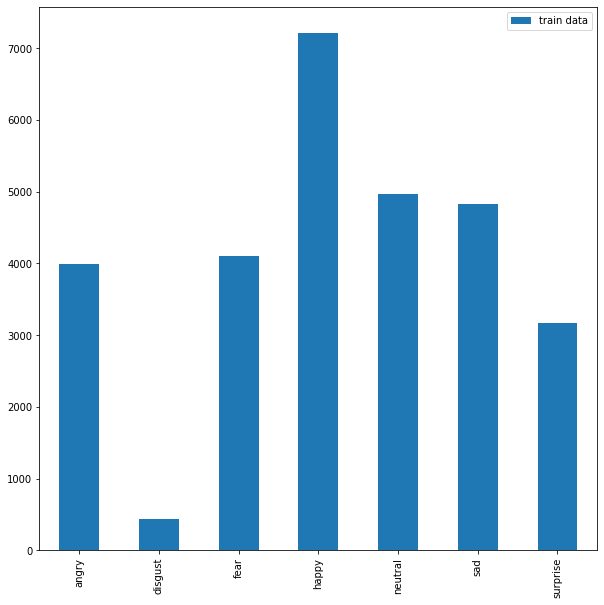

In [3]:
train_data_count.transpose().plot(kind='bar', figsize=(10,10))

### Bar chart for emotion images in test data

<AxesSubplot:>

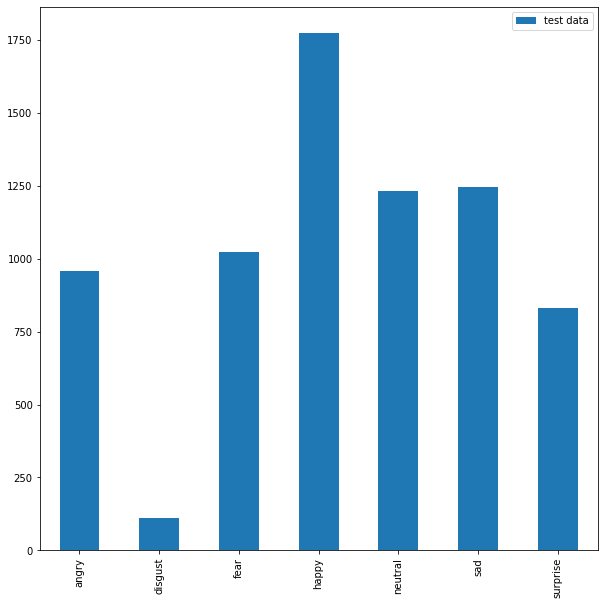

In [4]:
test_data_count.transpose().plot(kind='bar', figsize=(10,10))

### Examples of emotion images in dataset

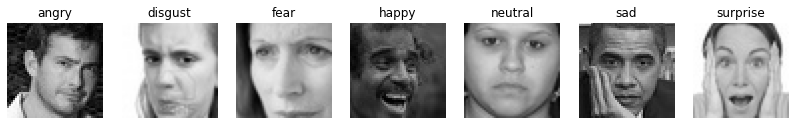

In [5]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_data_dir):
    img = load_img((train_data_dir + expression +'/'+ os.listdir(train_data_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

## Create Training and test datasets

In [6]:
train_data_generator = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_data_generator.flow_from_directory(train_data_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_data_generator = ImageDataGenerator(rescale=1./255)
test_set = test_data_generator.flow_from_directory(test_data_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Constructure Model

In [8]:
model = Sequential()   

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
    
model.add(Dense(classes, activation='softmax'))

model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

c:\Users\Grace\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Training Model

In [12]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size
hist = model.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - 12s 22ms/step - loss: 4.3645 - accuracy: 0.2811 - val_loss: 12.1270 - val_accuracy: 0.0292
Epoch 2/60
448/448 [==============================] - 9s 21ms/step - loss: 3.5240 - accuracy: 0.3401 - val_loss: 3.1232 - val_accuracy: 0.4213
Epoch 3/60
448/448 [==============================] - 10s 21ms/step - loss: 3.0340 - accuracy: 0.3726 - val_loss: 2.6997 - val_accuracy: 0.4322
Epoch 4/60
448/448 [==============================] - 10s 22ms/step - loss: 2.6193 - accuracy: 0.4073 - val_loss: 2.3295 - val_accuracy: 0.4689
Epoch 5/60
448/448 [==============================] - 10s 22ms/step - loss: 2.3025 - accuracy: 0.4291 - val_loss: 2.0853 - val_accuracy: 0.4750
Epoch 6/60
448/448 [==============================] - 10s 23ms/step - loss: 2.0582 - accuracy: 0.4472 - val_loss: 1.9368 - val_accuracy: 0.4747
Epoch 7/60
448/448 [==============================] - 10s 22ms/step - loss: 1.8636 - accuracy: 0.4669 - val_loss: 1.7211 - val_accuracy:

## Loss and Accuracy plot

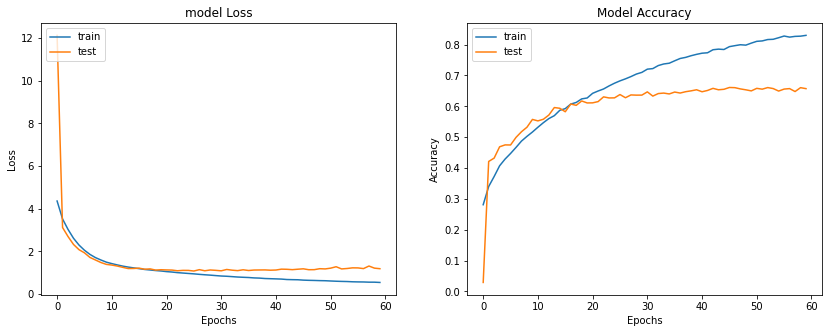

In [13]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

high accracy is achieved on training set but accuracy on validation set is stuck at 66% also no overfitting can se seen in the dataset hence is can be concluded that the inefficiency may be due to the unbalanced dataset

### Model evaluation

In [14]:
train_loss, train_accu = model.evaluate(training_set) #Evaluates train data for accuracy and loss 
test_loss, test_accu = model.evaluate(test_set) #Evaluates test data for accuracy and loss 
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 1s 9ms/step - loss: 1.1924 - accuracy: 0.6576
final train accuracy = 91.32 , validation accuracy = 65.76


### Serialize the model to JSON and save the model weights

In [15]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

### Import model weight and haar cascade file

In [18]:
from keras.models import model_from_json
from PIL import Image
model = model_from_json(open("model.json", "r").read())
model.load_weights('model.h5')
face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

### Construct frame to capture the image 

In [19]:
cap=cv2.VideoCapture(0) # Create an object to read from camera

while True:  
    ret,frame=cap.read()# Captures frame and returns boolean value  
    if not ret:  
        continue  
    gray_img= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  
  
    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)  
  
  
    for (x,y,w,h) in faces_detected:  
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),thickness=7)  
        roi_gray=gray_img[y:y+w,x:x+h] # Captures faces 
        roi_gray=cv2.resize(roi_gray,(48,48))  
        img_pixels = tf.keras.utils.img_to_array(roi_gray)  
        img_pixels = np.expand_dims(img_pixels, axis = 0)  
        img_pixels /= 255  
  
        predictions = model.predict(img_pixels)  
   
        max_index = np.argmax(predictions[0])  #Find max indexed array 
  
        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')  
        predicted_emotion = emotions[max_index]  
  
        cv2.putText(frame, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)  
  
    resized_img = cv2.resize(frame, (1000, 700))  
    cv2.imshow('Facial emotion analysis ',resized_img)  
  
  
    if cv2.waitKey(1) & 0xFF == ord('q'): #Press q to exit process
        break
cap.release()
cv2.destroyAllWindows() #Close all the windows

1/1 [==============================] - 0s 10ms/step
